# One-zone Two-infall models with Weinberg et al. (2023) yields

In [1]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
import vice
import paths
from multizone.src.models import twoinfall, insideout
from track_and_mdf import setup_figure, plot_vice_onezone
from vice.toolkit import J21_sf_law
from multizone.src import dtds
from utils import Exponential
import _globals

In [2]:
from multizone.src.yields import W23

In [3]:
plt.style.use(paths.styles / 'paper.mplstyle')
plt.rcParams['figure.dpi'] = 200

In [4]:
output_dir = paths.data / 'onezone' / 'W23'
output_dir.mkdir(parents=True, exist_ok=True)

In [5]:
dt = 0.01
tmax = _globals.END_TIME
simtime = np.arange(0, tmax+dt, dt)

In [6]:
r = 8
dr = 0.1
zone_area = np.pi * ((r+dr/2)**2 - (r-dr/2)**2)

In [7]:
def setup_onezone(name, func, mode='ifr'):
    sz = vice.singlezone(
        name=name,
        func=func,
        mode=mode,
        elements=('fe', 'o'),
        eta=0.5,
        Zin=0.,
        delay=0.04,
        RIa=dtds.exponential(timescale=1.5),
        Mg0=0,
        tau_star=2.,
        dt=dt,
        bins=[i*0.01 - 3 for i in range(401)],
    )
    return sz

## Inside-Out SFH

For $\tau_{\rm SFH}=15$ Gyr, the optimal mass-loading factor to achieve Solar equilibrium abundances is $\eta=0.5$.

In [8]:
recycling = 0.4
tau_star = 2
tau_sfh = 15
eta = vice.yields.ccsne.settings['o'] / vice.solar_z['o'] - 1 + 0.4 + tau_star / tau_sfh
eta

0.5061218709914871

Choice of SN Ia DTD does not affect the end point, so the yield values calculated for an exponential DTD will also work for other DTDs.

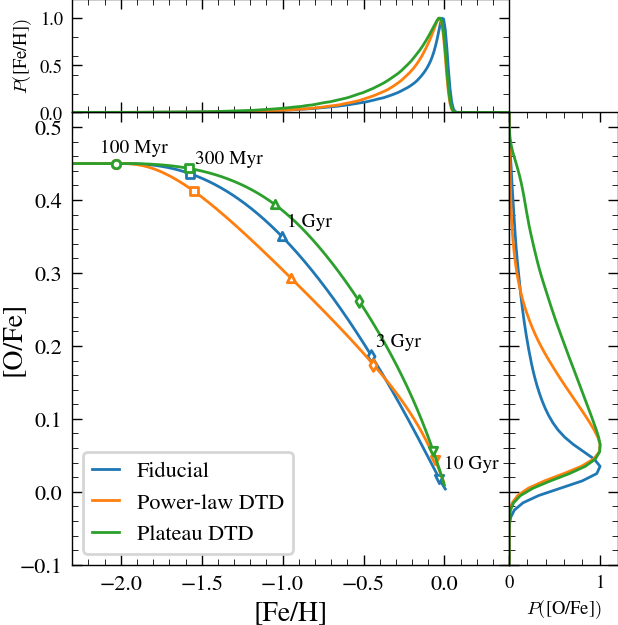

In [12]:
fig, axs = setup_figure(xlim=(-2.3, 0.4))

# Inside-out SFH
sfr = insideout(8)
name = str(output_dir / 'insideout')
sz = setup_onezone(name, sfr, mode='sfr')
sz.run(simtime, overwrite=True)
plot_vice_onezone(name, fig=fig, axs=axs, label='Fiducial', marker_labels=True)

name = str(output_dir / 'powerlaw_dtd')
sz = setup_onezone(name, sfr, mode='sfr')
sz.RIa = dtds.powerlaw()
sz.run(simtime, overwrite=True)
plot_vice_onezone(name, fig=fig, axs=axs, label='Power-law DTD', marker_labels=False)

name = str(output_dir / 'plateau_dtd')
sz = setup_onezone(name, sfr, mode='sfr')
sz.RIa = dtds.plateau()
sz.run(simtime, overwrite=True)
plot_vice_onezone(name, fig=fig, axs=axs, label='Plateau DTD', marker_labels=False)

axs[0].legend()
axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
plt.show()

## Exponential Infall

An exponentially declining infall history with a 15 Gyr timescale produces a nearly identical SFH to the inside-out SFH at the Solar radius. With a shorter infall timescale, however, we must compensate with a larger mass-loading factor

0.8727885376581538


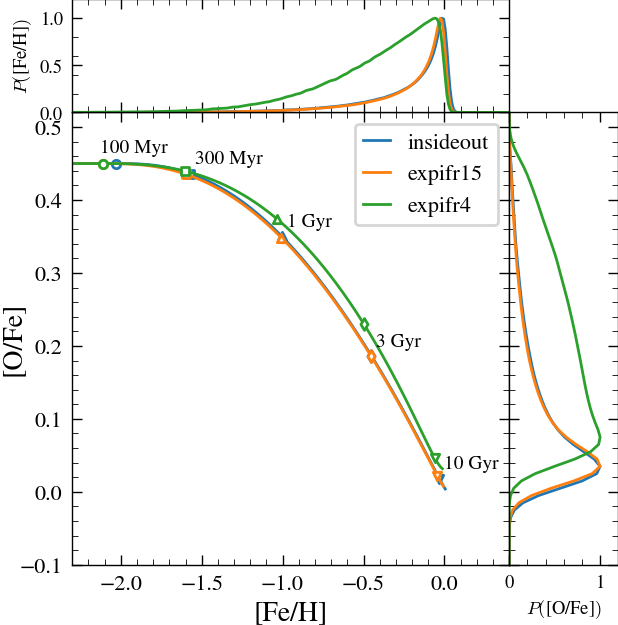

In [13]:
fig, axs = setup_figure(xlim=(-2.3, 0.4))

# Inside-out SFH
name = str(output_dir / 'insideout')
plot_vice_onezone(name, fig=fig, axs=axs, label='insideout', marker_labels=True)

# Exponential infall
ifr = Exponential(scale=-15, coeff=0.3)
name = str(output_dir / 'expifr15')
sz = setup_onezone(name, ifr, mode='ifr')
sz.run(simtime, overwrite=True)
plot_vice_onezone(name, fig=fig, axs=axs, label='expifr15', marker_labels=False)

# Exponential infall
tau_sfh = 4
vice.yields.sneia.settings['fe'] *= (1.1/1.6)
eta = vice.yields.ccsne.settings['o'] / vice.solar_z['o'] - 1 + 0.4 + tau_star / tau_sfh
print(eta)
ifr = Exponential(scale=-4, coeff=1.)
name = str(output_dir / 'expifr4')
sz = setup_onezone(name, ifr, mode='ifr')
sz.eta = eta
sz.run(simtime, overwrite=True)
plot_vice_onezone(name, fig=fig, axs=axs, label='expifr4', marker_labels=False)

axs[0].legend()
axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
plt.show()

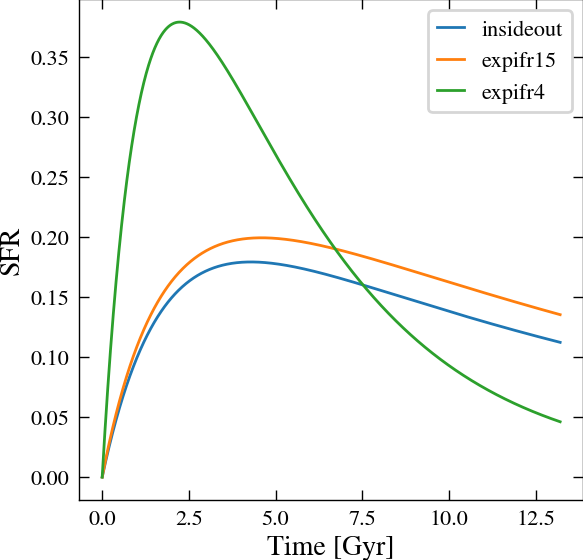

In [16]:
fig, ax = plt.subplots()
for name in ['insideout', 'expifr15', 'expifr4']:
    hist = vice.history(str(output_dir / name))
    ax.plot(hist['time'], hist['sfr'], label=name)

ax.legend()
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel('SFR')
plt.show()

## Outflows

/home/lodubay/anaconda3/lib/python3.10/site-packages/vice/core/singlezone/singlezone.py:842: ScienceWarning: Closed-box GCE models have been shown to overpredict the metallicities of solar neighborhood stars. This was known as the G-dwarf problem (Tinsley 1980, Fundamentals of Cosmic Phys., 5, 287). Outflows have been shown to be necessary for maintaining long-term chemical equilibrium (Dalcanton 2007, ApJ, 658, 941).
  self.__c_version.eta = value


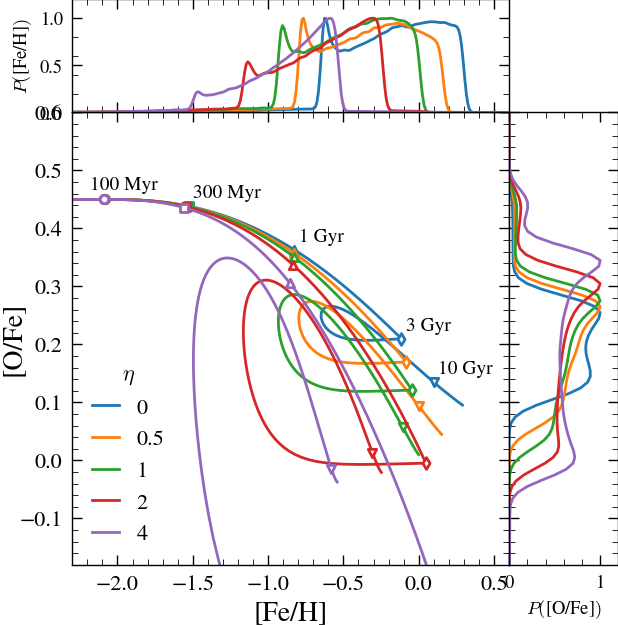

In [10]:
fig, axs = setup_figure(xlim=(-2.3, 0.6), ylim=(-0.18, 0.6))

ifr = twoinfall(8, onset=3, first_timescale=0.3, second_timescale=3)

eta_list = [0, 0.5, 1, 2, 4]
for eta in eta_list:
    name = str(output_dir / f'eta{eta}')
    sz = setup_onezone(name, ifr)
    sz.eta = eta
    sz.run(simtime, overwrite=True)
    plot_vice_onezone(name, fig=fig, axs=axs,
                      label=f'{eta}',
                      marker_labels=(eta==0))

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left', title=r'$\eta$')
plt.show()

## Infall metallicity

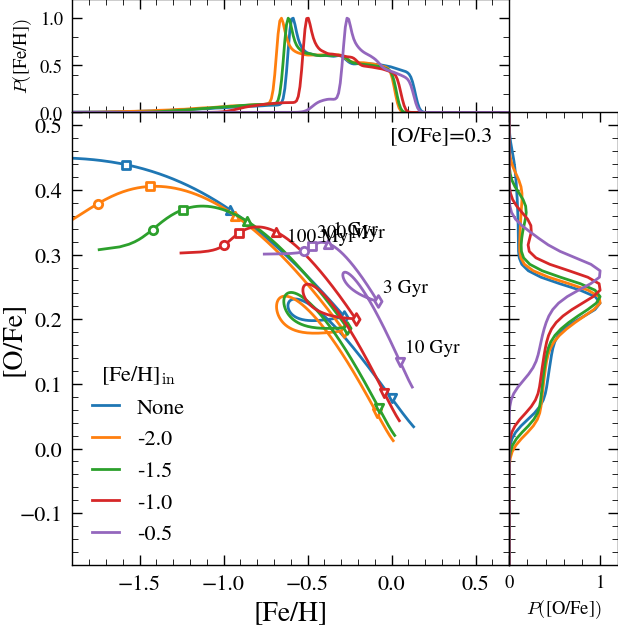

In [12]:
fig, axs = setup_figure(xlim=(-1.9, 0.7), ylim=(-0.18, 0.52))

ifr = twoinfall(8, onset=3, first_timescale=1, second_timescale=3)

# No infall enrichment
name = str(output_dir / 'ZinNone')
sz = setup_onezone(name, ifr)
sz.eta = 0.6
sz.Mg0 = 1e6
sz.run(simtime, overwrite=True)
plot_vice_onezone(name, fig=fig, axs=axs,
                  label='None',
                  marker_labels=False)

feh_list = [-2., -1.5, -1., -0.5]
Zin_list = [10 ** (feh + m.log10(vice.solar_z['fe'])) for feh in feh_list]
ofe_in = 0.3
Zo_in_list = [vice.solar_z['o'] * 10 ** (ofe_in + feh) for feh in feh_list]
for i, Zin in enumerate(Zin_list):
    name = str(output_dir / f'Zin{int(-10*feh_list[i]):02d}')
    sz = setup_onezone(name, ifr)
    sz.eta = 1.
    sz.Zin = {'fe': Zin, 'o': Zo_in_list[i]}
    # Non-zero initial mass to avoid crazy high metallicities from inflow
    sz.Mg0 = 1e7
    sz.run(simtime, overwrite=True)
    plot_vice_onezone(name, fig=fig, axs=axs,
                      label=f'{feh_list[i]}',
                      marker_labels=(i==3))

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left', title=r'[Fe/H]$_{\rm in}$')
axs[0].text(0.6, 0.5, f'[O/Fe]={ofe_in}', ha='right', va='top')
plt.show()